## Make a simple synthetic dataset to test hierarchical merge in FOF algorithm

#### the idea is this: 

* after the local FOF stage, each partition reports the particles it holds in the overlap region
* do a reduceByKey or treeAggregate of some sort to collect the groups belonging to the same particles
* produce a mapping of $G -> G_1$ and distribute to all hosts in form of broadcast lookup table

In [23]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

import sys
sys.setrecursionlimit(sys.getrecursionlimit()*10)
import matplotlib.patches as patches

plt.style.use('default')

In [2]:
import findspark
findspark.init()

In [3]:
def plot_rectangle(rec, ax=None):
    if ax is None: 
        ax = plt.subplot(aspect='equal')
    
    if isinstance(rec, (list, tuple)):
        for r in rec: 
            plot_rectangle(r,ax)
    
    else:
        size = (rec.maxes-rec.mins)
        ax.add_patch(patches.Rectangle(rec.mins, size[0], size[1], fill=False, zorder=-1))
    plt.draw()
    plt.show()

## Start Spark

In [4]:
import os
os.environ['SPARK_CONF_DIR'] = './conf'
os.environ['SPARK_DRIVER_MEMORY'] = '8G'

In [5]:
import pyspark
from pyspark import SparkContext, SparkConf
import pynbody
import sparkhpc

In [47]:
sj = sparkhpc.sparkjob.LSFSparkJob(ncores=27, memory=8500, walltime='4:00')
sj.wait_to_start()

INFO:sparkhpc:Submitted cluster 0


In [48]:
conf = SparkConf()

In [49]:
conf.set('spark.python.profile', 'true')
conf.set('spark.executor.memory', '8G')
conf.set('spark.driver.memory', '8G')
conf.set('spark.driver.maxResultSize', '5G')

In [52]:
sc = SparkContext(master=sj.master_url(), conf=conf)

In [53]:
sj.master_ui()

'http://10.205.7.22:8080'

### Make the base RDD

In [54]:
def convert_to_fof_particle(s): 
    p_arr = np.frombuffer(s, pdt_tipsy)
    
    new_arr = np.zeros(len(p_arr), dtype=pdt)
    new_arr['pos'] = p_arr['pos']
    
    return new_arr

In [55]:
def get_minmax(index, i): 
    mins = []
    maxs = []
    for arr in i: 
        mins.append(arr['pos'].min(axis=0))
        maxs.append(arr['pos'].max(axis=0))
    
    yield (index, (np.concatenate(mins).reshape(len(mins),3).min(axis=0), np.concatenate(maxs).reshape(len(mins),3).max(axis=0)))

In [56]:
from pyspark.accumulators import AccumulatorParam

class dictAdd(AccumulatorParam):
    def zero(self, value):
        return {i:0 for i in range(len(value))}
    def addInPlace(self, val1, val2): 
        for k, v in val2.iteritems(): 
            val1[k] += v
        return val1

In [57]:
from spark_fof.spark_fof_c import pdt
from spark_fof.spark_fof import partition_helper

In [58]:
# function to map from file block numbers to domain bin
N = 62
map_file_to_domain = lambda (x,y,z): (x-1) + (y-1)*N + (z-1)*N*N

pdt_lc = np.dtype([('pos', 'f4', 3),('vel', 'f4', 3)])

import re
import time

get_block_ids = re.compile('blk\.(\d+)\.(\d+)\.(\d+)i')

def make_lc_rdd(sc, path):
    from glob import glob

    def set_particle_IDs_partition(index, iterator): 
        p_counts = partition_counts.value
        local_index = 0
        start_index = sum([p_counts[i] for i in range(index)])
        for arr in iterator:
            arr['iOrder'] = range(start_index + local_index, start_index + local_index + len(arr))
            arr['iGroup'] = index
            local_index += len(arr)
            yield arr
    
    def read_file(index, i, chunksize=102400): 
        for part,filename in i:
            timein = time.time()
            with open(filename,'rb') as f: 
                header = f.read(62500)
                while True:
                    chunk = f.read(chunksize*24)
                    if len(chunk): 
                        p_arr = np.frombuffer(chunk, pdt_lc)
                        new_arr = np.zeros(len(p_arr), dtype=pdt)
                        new_arr['pos'] = p_arr['pos']
                        npart_acc.add({index: len(p_arr)})
                        yield new_arr
                    else: 
                        print 'reading %s took %d seconds in partition %d'%(filename, time.time()-timein, index)
                        break
                    
    files = glob('/cluster/home/roskarr/scratch/euclid/2Tlc-final/*/*')

    ids = map(lambda x: tuple(map(int, get_block_ids.findall(x)[0])), files)
    ids_map = {x:i for i,x in enumerate(ids)}
    ids_map_b = sc.broadcast(ids_map)
    ids_map_inv = {v:k for k,v in ids_map.iteritems()}
    nfiles = len(files)
    
    print 'Number of input files: ', nfiles
    
    # set the partition count accumulator
    npart_acc = sc.accumulator({i:0 for i in range(nfiles)}, dictAdd())
    
    rec_rdd = (sc.parallelize(zip(ids,files), numSlices=sc.defaultParallelism)
                 .map(lambda (id,filename): (ids_map_b.value[id],filename))
                 .partitionBy(sc.defaultParallelism)
                 .mapPartitionsWithIndex(read_file, preservesPartitioning=True))
  
    rec_rdd.count()
    partition_counts = sc.broadcast(npart_acc.value)
    
    return partition_counts, ids_map, rec_rdd.mapPartitionsWithIndex(set_particle_IDs_partition, 
                                                                     preservesPartitioning=True)

In [59]:
sc.defaultParallelism

27

In [60]:
%%time 
p_counts, ids_map, p_rdd = make_lc_rdd(sc, '2Tlc-final/')
p_rdd.cache()
#p_rdd.count()


Number of input files:  27
CPU times: user 48 ms, sys: 18 ms, total: 66 ms
Wall time: 3min 35s


In [61]:
%time limits = p_rdd.mapPartitionsWithIndex(get_minmax).collect()

CPU times: user 23 ms, sys: 4 ms, total: 27 ms
Wall time: 55.8 s


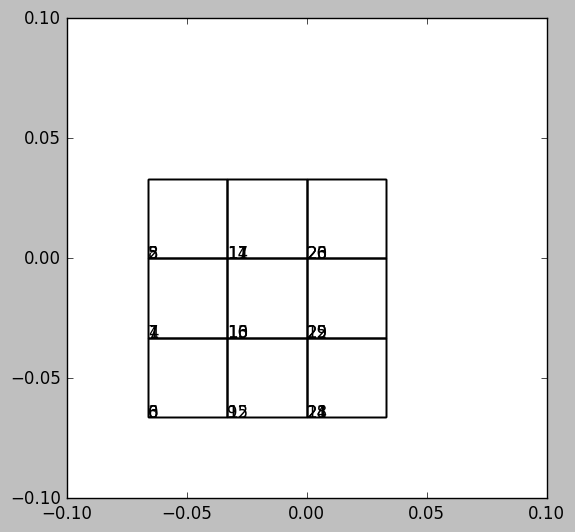

In [64]:
ax = plt.subplot(aspect='equal')
for i in range(len(limits)):
    x = 0
    y = 2
    mins = limits[i][1][0]
    maxs = limits[i][1][1]
    size = maxs-mins
    ax.add_patch(patches.Rectangle((mins[x],mins[y]),size[0], size[1], fill=False))
    ax.text(mins[x],mins[y], str(i))
ax.set_xlim(-0.1,.1)
ax.set_ylim(-.1,.1)
plt.draw()
plt.show()

### Preliminaries, setting the domain size and global grid mapping

In [65]:
#diff = (limits[0][1][1] - limits[0][1][0])[0]

In [66]:
#diff = (limits[0][1][1] - limits[0][1][0])[0]
diff = np.float32(0.033068776)
global_min = -31*diff
global_max = 31*diff

diff, global_min, global_max

(0.033068776, -1.0251320600509644, 1.0251320600509644)

In [67]:
dom_maxs = np.array([global_max]*3, dtype=np.float64)
dom_mins = np.array([global_min]*3, dtype=np.float64)

#tau = diff*5./125.
tau = 0.2/12600
buffer_tau = diff*5./150.

global_to_cutout_map = {}
for k,v in ids_map.iteritems(): 
    global_to_cutout_map[map_file_to_domain(k)] = v

### Run FOF and Merge groups

In [68]:
import spark_fof

In [77]:
reload(spark_fof.spark_fof)
reload(spark_fof.spark_fof_c)

fof_analyzer = spark_fof.spark_fof.FOFAnalyzer(sc, p_rdd, 64, 62, tau, dom_mins, dom_maxs, Npartitions=27, buffer_tau=tau*2)

In [78]:
### THIS MUST BE FIXED IN THE MAIN CODE
fof_analyzer.global_to_local_map = global_to_cutout_map

In [33]:
ghost_rdd.mapPartitionsWithIndex(get_particle).collect()

[(0,
  array([ ([-0.06549075990915298, -0.06591714173555374, 4.859391992795281e-06], 2, 75441603, 0)], 
        dtype={'names':['pos','is_ghost','iOrder','iGroup'], 'formats':[('<f4', (3,)),'<i4','<i4','<i8'], 'offsets':[0,12,16,24], 'itemsize':32}))]

In [34]:
tot_rdd = (p_rdd+ghost_rdd).cache()

In [75]:
def ghost_counts(index, iterator): 
    nghosts = 0
    nghosts_copy = 0
    nother = 0
    for arr in iterator: 
        nghosts += len(np.where(arr['is_ghost']==1)[0])
        nghosts_copy += len(np.where(arr['is_ghost']==2)[0])
        nother += len(np.where(arr['is_ghost']==0)[0])
    yield index,nother,nghosts,nghosts_copy

In [37]:
tot_rdd.mapPartitionsWithIndex(ghost_counts).collect()

[(0, 75258991, 181981, 64763),
 (1, 74374559, 230569, 35),
 (2, 68408703, 185563, 17),
 (3, 66225895, 206117, 19),
 (4, 75029145, 213954, 14),
 (5, 73326694, 216637, 8)]

In [79]:
fof_analyzer.partitioned_rdd.mapPartitionsWithIndex(ghost_counts).collect()

[(0, 78478527, 201843, 107617),
 (1, 75258991, 181981, 129652),
 (2, 74374559, 230569, 68660),
 (3, 68232531, 255883, 89734),
 (4, 68408703, 185563, 98122),
 (5, 71740639, 183043, 92251),
 (6, 83603927, 183403, 86346),
 (7, 77298050, 225537, 63527),
 (8, 78256382, 260124, 42203),
 (9, 87197517, 247255, 116341),
 (10, 77312360, 266434, 113134),
 (11, 75652433, 223673, 50061),
 (12, 72417374, 195769, 108231),
 (13, 65432813, 208527, 105646),
 (14, 65418462, 220691, 78575),
 (15, 69972413, 226315, 66948),
 (16, 71668036, 167084, 65595),
 (17, 66225895, 206117, 37555),
 (18, 75029145, 213954, 59292),
 (19, 73644945, 179816, 75582),
 (20, 69942696, 184027, 29550),
 (21, 74174404, 205441, 82868),
 (22, 73326694, 216637, 81198),
 (23, 75894895, 255947, 29787),
 (24, 64415316, 214295, 32712),
 (25, 69249172, 196687, 32135),
 (26, 64389219, 196369, 214)]

In [41]:
fof_analyzer.partitioned_rdd.mapPartitionsWithIndex(get_particle).collect()

[(0,
  array([ ([-0.06549075990915298, -0.06591714173555374, 4.859391992795281e-06], 2, 75441603, 0)], 
        dtype={'names':['pos','is_ghost','iOrder','iGroup'], 'formats':[('<f4', (3,)),'<i4','<i4','<i8'], 'offsets':[0,12,16,24], 'itemsize':32})),
 (1,
  array([ ([-0.06549075990915298, -0.06591714173555374, 4.859391992795281e-06], 1, 75441603, 1)], 
        dtype={'names':['pos','is_ghost','iOrder','iGroup'], 'formats':[('<f4', (3,)),'<i4','<i4','<i8'], 'offsets':[0,12,16,24], 'itemsize':32, 'aligned':True}))]

In [27]:
fof_analyzer.partitioned_rdd.first()

(1,
 array([ ([-0.06611280888319016, -0.06487394124269485, -6.162966315059748e-07], 2, 106656, 120991)], 
       dtype={'names':['pos','is_ghost','iOrder','iGroup'], 'formats':[('<f4', (3,)),'<i4','<i4','<i8'], 'offsets':[0,12,16,24], 'itemsize':32}))

In [26]:
%%time 
fof_rdd = fof_analyzer.fof_rdd
fof_rdd.count()

Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.collectAndServe.
: org.apache.spark.SparkException: Job 1 cancelled because Stage 3 was cancelled
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1454)
	at org.apache.spark.scheduler.DAGScheduler.handleJobCancellation(DAGScheduler.scala:1393)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleStageCancellation$1.apply$mcVI$sp(DAGScheduler.scala:1381)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleStageCancellation$1.apply(DAGScheduler.scala:1380)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleStageCancellation$1.apply(DAGScheduler.scala:1380)
	at scala.collection.IndexedSeqOptimized$class.foreach(IndexedSeqOptimized.scala:33)
	at scala.collection.mutable.ArrayOps$ofInt.foreach(ArrayOps.scala:234)
	at org.apache.spark.scheduler.DAGScheduler.handleStageCancellation(DAGScheduler.scala:1380)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:1636)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1622)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1611)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:632)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1890)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1903)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1916)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1930)
	at org.apache.spark.rdd.RDD$$anonfun$collect$1.apply(RDD.scala:912)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:358)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:911)
	at org.apache.spark.api.python.PythonRDD$.collectAndServe(PythonRDD.scala:453)
	at org.apache.spark.api.python.PythonRDD.collectAndServe(PythonRDD.scala)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:483)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:237)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:280)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:214)
	at java.lang.Thread.run(Thread.java:745)


In [43]:
groups_map = fof_analyzer.get_gid_map()

In [57]:
groups_map[-100:]

[(187712519, [22718341, 8597718772]),
 (336935039, [17192391212]),
 (5495519, [315726]),
 (360380159, [21474866371]),
 (221241719, [12893702890]),
 (219726599, [12886923737]),
 (218772119, [12889181503]),
 (76771439, [4298880967]),
 (178360319, [8606405082]),
 (234608399, [12886113526]),
 (276204959, [12903994905]),
 (332527559, [17198841333]),
 (337395479, [17198860126]),
 (219281999, [12891009899]),
 (333656879, [17184026571]),
 (268032719, [12903967469]),
 (361362719, [21477354994]),
 (94208879, [4297439901]),
 (181211039, [8606049294]),
 (87392039, [4295556202]),
 (226168199, [12892418252]),
 (404335919, [21490747658]),
 (135331799, [30753670, 4308152254]),
 (137023799, [16172328, 4305427348]),
 (540239, [9958967]),
 (286368479, [17182024327]),
 (346165919, [17200787403]),
 (386967359, [21476011626]),
 (248648999, [12894256160]),
 (287115119, [17202984350]),
 (22929359, [1588311]),
 (132319559, [4318929975]),
 (286514759, [17202891580]),
 (378145919, [21480439674]),
 (36007559, [41

In [58]:
get_particle(fof_rdd,187712519)

[(0,
  array([ ([-0.046928294003009796, -0.033064354211091995, -0.024187374860048294], 2, 187712519, 22718341)], 
        dtype={'names':['pos','is_ghost','iOrder','iGroup'], 'formats':[('<f4', (3,)),'<i4','<i4','<i8'], 'offsets':[0,12,16,24], 'itemsize':32, 'aligned':True})),
 (2,
  array([ ([-0.046928294003009796, -0.033064354211091995, -0.024187374860048294], 1, 187712519, 8597718772)], 
        dtype={'names':['pos','is_ghost','iOrder','iGroup'], 'formats':[('<f4', (3,)),'<i4','<i4','<i8'], 'offsets':[0,12,16,24], 'itemsize':32, 'aligned':True}))]

In [64]:
ghost_copy_rdd = fof_rdd.flatMap(lambda p: p[np.where(p['is_ghost']==2)[0]]).map(spark_fof.spark_fof.pid_gid)
ghost_orig_rdd = fof_rdd.flatMap(lambda p: p[np.where(p['is_ghost']==1)[0]]).map(spark_fof.spark_fof.pid_gid)

In [65]:
ghost_copy_rdd.first()

(75440972, 9049620)

In [66]:
ghost_orig_rdd.first()

(0, 12)

In [77]:
join_rdd = ghost_copy_rdd.join(ghost_orig_rdd).mapValues(lambda x: sorted(x)).flatMap(lambda gs: [(g, gs[0]) for g in gs[1:]]).cache()

In [82]:
groups_map = (ghost_copy_rdd.join(ghost_orig_rdd)
                            .map(lambda (k,v): sorted(v))
                            .flatMap(lambda gs: [(g, gs[0]) for g in gs[1:]])).collect()

In [84]:
src, dst = zip(*groups_map)

In [85]:
import networkx as nx

In [87]:
g = nx.Graph()
g.add_nodes_from(src + dst)
for e in groups_map:
    g.add_edge(*e)
mappings = {}
for sg in nx.connected.connected_component_subgraphs(g):
    if len(sg) > 1:
        # generate mapping to lowest-common-group
        base_node = min(sg.nodes())
        new_mapping = {
            node: base_node for node in sg.nodes() if node != base_node}
        mappings.update(new_mapping)

In [93]:
level_map = fof_analyzer.get_level_map()

KeyboardInterrupt: 

In [90]:
mappings

{4298113024: 12765555,
 8601600000: 27698902,
 8594391042: 25786838,
 4302962691: 12980133,
 4302962692: 12980131,
 4298244102: 14066780,
 4298244103: 14066782,
 8601600008: 27698628,
 4307419145: 30018905,
 8601600012: 27698634,
 4298244098: 14066752,
 8601600014: 27698797,
 4298244111: 14066874,
 8601600019: 27698670,
 8601600020: 27698669,
 8601600021: 27698811,
 8592490519: 19887373,
 8589934617: 17004161,
 8601600026: 27698852,
 8601600027: 27698851,
 8601600028: 27698845,
 8592490525: 19887376,
 8589934625: 17004377,
 4294967331: 9049628,
 4294967332: 9049620,
 4302962694: 12980136,
 8601600038: 27665628,
 8601600039: 27665628,
 4300013608: 25784073,
 8601600041: 27698998,
 8601600042: 27698949,
 4300013611: 25784075,
 4300013612: 25784183,
 8589934637: 17004300,
 8589934639: 17004381,
 8590273203: 18878890,
 8601600052: 27698717,
 8589934647: 17004221,
 8601600056: 27698795,
 8592490553: 19912114,
 8601600060: 27698818,
 8589934654: 17004250,
 8601600063: 27698815,
 8601600065: 

In [ ]:
from spark_fof.spark_fof import get_bin

domain_containers = fof_analyzer.domain_containers

mins = fof_analyzer.mins
maxs = fof_analyzer.maxs
nbins = fof_analyzer.nBins

global_to_local_map = fof_analyzer.global_to_local_map
gl_to_loc_map_b = sc.broadcast(global_to_local_map)

def set_bin(pos): 
    pos = np.array(pos, dtype=np.float32)
    gl_to_loc_map = gl_to_loc_map_b.value
    
    mybin = get_bin(np.array(pos, dtype=np.float32),nbins,mins,maxs)
    
    
set_bin = lambda pos: gl_to_loc_map_b.value[get_bin(np.array(pos, dtype=np.float32),nbins,mins,maxs)]

def get_bin2(particles):
    for p in particles:
        b = get_bin(p['pos'],nbins,mins,maxs)
        if b in gl_to_loc_map_b.value:
            yield (gl_to_loc_map_b.value[b], p)
    

In [ ]:
groups_map = (fof_rdd.flatMap(lambda p: p[np.where(p['is_ghost'])[0]])
                     .mapPartitions(get_bin2)
                     .partitionBy(6)).cache()
#                       .map(lambda (partition_id, (particle_id,group_id)): (particle_id,group_id), 
#                            preservesPartitioning=True))
#                      .aggregateByKey([], lambda l, g: l + [g], lambda a, b: sorted(a + b), 
#                                      partitionFunc=set_bin))
#                      .values()
#                      .flatMap(lambda gs: [(g, gs[0]) for g in gs[1:]])).collect()

In [ ]:
groups_map.first()

In [27]:
x = fof_rdd.flatMap(lambda p: p[np.where(p['is_ghost']>0)[0]]).map(lambda p: (get_bin(p['pos'],nbins,mins,maxs), p))

In [39]:
fof_rdd.flatMap(lambda p: p[np.where(p['is_ghost']==2)[0]])\
       .mapPartitions(get_bin2).take(20)

[(78680421, 1),
 (78680422, 1),
 (78680429, 1),
 (78680434, 1),
 (78680538, 1),
 (78680710, 1),
 (78680712, 1),
 (78787492, 1),
 (78787559, 1),
 (78787861, 1),
 (78787961, 1),
 (78787964, 1),
 (78787968, 1),
 (78788236, 1),
 (78788237, 1),
 (78788238, 1),
 (78788240, 1),
 (78788244, 1),
 (78788595, 1),
 (78788596, 1)]

In [28]:
bad = x.filter(lambda (binid,p): binid not in gl_to_loc_map_b.value).collect()

In [34]:
fof_rdd.flatMap(lambda x: x[np.where(x['is_ghost']==2)[0]]).take(20)

[([-0.06573289632797241, -0.06575457006692886, -0.06612294912338257], 1, 0, 12),
 ([-0.06573054194450378, -0.06575792282819748, -0.06612083315849304], 1, 1, 12),
 ([-0.0657329186797142, -0.06576550006866455, -0.06612081825733185], 1, 2, 12),
 ([-0.06572426110506058, -0.06575217097997665, -0.0661124736070633], 1, 3, 12),
 ([-0.06572258472442627, -0.06576202064752579, -0.06610748916864395], 1, 4, 12),
 ([-0.06572159379720688, -0.06575781106948853, -0.06611243635416031], 1, 5, 12),
 ([-0.06577809154987335, -0.06563536077737808, -0.06611169129610062], 1, 6, 22),
 ([-0.06577938795089722, -0.06562937796115875, -0.06611119955778122], 1, 7, 22),
 ([-0.0657726302742958, -0.06563825905323029, -0.06612486392259598], 1, 8, 22),
 ([-0.0657418817281723, -0.06561712920665741, -0.0660964697599411], 1, 9, 22),
 ([-0.06573700904846191, -0.0656098797917366, -0.06609456986188889], 1, 10, 22),
 ([-0.06577926874160767, -0.06562548875808716, -0.06606430560350418], 1, 11, 22),
 ([-0.06577067077159882, -0.0656

In [44]:
fof_analyzer.partitioned_rdd.flatMap(lambda p: p[np.where(p['iOrder']==4721)]).take(2)

[([-0.0655440017580986, -0.06568702310323715, -0.06613755971193314], 2, 4721, 0)]

In [39]:
fof_rdd.flatMap(lambda x: x[np.where(x['iOrder']==78788236)]).take(2)

[([-0.06543324887752533, -0.06370767951011658, -0.033066850155591965], 2, 78788236, 10066285),
 ([-0.06543324887752533, -0.06370767951011658, -0.033066850155591965], 1, 78788236, 4294980728)]

In [45]:
ids_map

{(30, 30, 30): 0,
 (30, 30, 31): 1,
 (30, 30, 32): 2,
 (30, 31, 30): 3,
 (30, 31, 31): 4,
 (30, 31, 32): 5,
 (30, 32, 30): 6,
 (30, 32, 31): 7,
 (30, 32, 32): 8,
 (31, 30, 30): 9,
 (31, 30, 31): 10,
 (31, 30, 32): 11,
 (31, 31, 30): 12,
 (31, 31, 31): 13,
 (31, 31, 32): 14,
 (31, 32, 30): 15,
 (31, 32, 31): 16,
 (31, 32, 32): 17,
 (32, 30, 30): 18,
 (32, 30, 31): 19,
 (32, 30, 32): 20,
 (32, 31, 30): 21,
 (32, 31, 31): 22,
 (32, 31, 32): 23,
 (32, 32, 30): 24,
 (32, 32, 31): 25,
 (32, 32, 32): 26}

In [30]:
global_to_local_map

{113303: 0,
 113304: 9,
 113305: 18,
 113365: 3,
 113366: 12,
 113367: 21,
 113427: 6,
 113428: 15,
 113429: 24,
 117147: 1,
 117148: 10,
 117149: 19,
 117209: 4,
 117210: 13,
 117211: 22,
 117271: 7,
 117272: 16,
 117273: 25,
 120991: 2,
 120992: 11,
 120993: 20,
 121053: 5,
 121054: 14,
 121055: 23,
 121115: 8,
 121116: 17,
 121117: 26}

In [29]:
groups_map.take(20)

Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.runJob.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 11.0 failed 4 times, most recent failure: Lost task 0.3 in stage 11.0 (TID 232, 10.205.8.59): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/cluster/home/roskarr/spark/python/lib/pyspark.zip/pyspark/worker.py", line 170, in main
    profiler.profile(process)
  File "/cluster/home/roskarr/spark/python/lib/pyspark.zip/pyspark/profiler.py", line 160, in profile
    pr.runcall(func)
  File "/cluster/home/roskarr/miniconda2/lib/python2.7/cProfile.py", line 149, in runcall
    return func(*args, **kw)
  File "/cluster/home/roskarr/spark/python/lib/pyspark.zip/pyspark/worker.py", line 167, in process
    serializer.dump_stream(func(split_index, iterator), outfile)
  File "/cluster/home/roskarr/spark/python/lib/pyspark.zip/pyspark/serializers.py", line 133, in dump_stream
    for obj in iterator:
  File "/cluster/home/roskarr/spark/python/pyspark/rdd.py", line 1719, in add_shuffle_key
    buckets[partitionFunc(k) % numPartitions].append((k, v))
  File "<ipython-input-28-bbeec40f7b7f>", line 12, in <lambda>
KeyError: 109459

	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRDD.scala:193)
	at org.apache.spark.api.python.PythonRunner$$anon$1.next(PythonRDD.scala:156)
	at org.apache.spark.api.python.PythonRunner$$anon$1.next(PythonRDD.scala:152)
	at org.apache.spark.InterruptibleIterator.next(InterruptibleIterator.scala:43)
	at scala.collection.Iterator$GroupedIterator.takeDestructively(Iterator.scala:1076)
	at scala.collection.Iterator$GroupedIterator.go(Iterator.scala:1091)
	at scala.collection.Iterator$GroupedIterator.fill(Iterator.scala:1129)
	at scala.collection.Iterator$GroupedIterator.hasNext(Iterator.scala:1132)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:408)
	at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.write(BypassMergeSortShuffleWriter.java:147)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:79)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:47)
	at org.apache.spark.scheduler.Task.run(Task.scala:86)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:274)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1142)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:617)
	at java.lang.Thread.run(Thread.java:745)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1454)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1442)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1441)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1441)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:811)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:811)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:811)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:1667)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1622)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1611)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:632)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1890)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1903)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1916)
	at org.apache.spark.api.python.PythonRDD$.runJob(PythonRDD.scala:441)
	at org.apache.spark.api.python.PythonRDD.runJob(PythonRDD.scala)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:483)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:237)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:280)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:214)
	at java.lang.Thread.run(Thread.java:745)
Caused by: org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/cluster/home/roskarr/spark/python/lib/pyspark.zip/pyspark/worker.py", line 170, in main
    profiler.profile(process)
  File "/cluster/home/roskarr/spark/python/lib/pyspark.zip/pyspark/profiler.py", line 160, in profile
    pr.runcall(func)
  File "/cluster/home/roskarr/miniconda2/lib/python2.7/cProfile.py", line 149, in runcall
    return func(*args, **kw)
  File "/cluster/home/roskarr/spark/python/lib/pyspark.zip/pyspark/worker.py", line 167, in process
    serializer.dump_stream(func(split_index, iterator), outfile)
  File "/cluster/home/roskarr/spark/python/lib/pyspark.zip/pyspark/serializers.py", line 133, in dump_stream
    for obj in iterator:
  File "/cluster/home/roskarr/spark/python/pyspark/rdd.py", line 1719, in add_shuffle_key
    buckets[partitionFunc(k) % numPartitions].append((k, v))
  File "<ipython-input-28-bbeec40f7b7f>", line 12, in <lambda>
KeyError: 109459

	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRDD.scala:193)
	at org.apache.spark.api.python.PythonRunner$$anon$1.next(PythonRDD.scala:156)
	at org.apache.spark.api.python.PythonRunner$$anon$1.next(PythonRDD.scala:152)
	at org.apache.spark.InterruptibleIterator.next(InterruptibleIterator.scala:43)
	at scala.collection.Iterator$GroupedIterator.takeDestructively(Iterator.scala:1076)
	at scala.collection.Iterator$GroupedIterator.go(Iterator.scala:1091)
	at scala.collection.Iterator$GroupedIterator.fill(Iterator.scala:1129)
	at scala.collection.Iterator$GroupedIterator.hasNext(Iterator.scala:1132)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:408)
	at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.write(BypassMergeSortShuffleWriter.java:147)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:79)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:47)
	at org.apache.spark.scheduler.Task.run(Task.scala:86)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:274)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1142)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:617)
	... 1 more


In [101]:
def pid_gid(p):
    """Map the particle to its pid and gid"""
    return (p['iOrder'], p['iGroup'])


In [ ]:
(fof_analyzer.fof_rdd.flatMap(lambda p: p[np.where(p['is_ghost'])[0]])
                             .map(lambda p: (p['pos'], p))
                             .mapValues(pid_gid)).count()

In [268]:
merged_rdd = fof_analyzer.merged_rdd.cache()
merged_rdd.count()

Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.collectAndServe.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 3 in stage 96.0 failed 4 times, most recent failure: Lost task 3.3 in stage 96.0 (TID 342, 10.205.7.45): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/cluster/home/roskarr/spark/python/lib/pyspark.zip/pyspark/worker.py", line 170, in main
    profiler.profile(process)
  File "/cluster/home/roskarr/spark/python/lib/pyspark.zip/pyspark/profiler.py", line 160, in profile
    pr.runcall(func)
  File "/cluster/home/roskarr/miniconda2/lib/python2.7/cProfile.py", line 149, in runcall
    return func(*args, **kw)
  File "/cluster/home/roskarr/spark/python/lib/pyspark.zip/pyspark/worker.py", line 167, in process
    serializer.dump_stream(func(split_index, iterator), outfile)
  File "/cluster/home/roskarr/spark/python/pyspark/rdd.py", line 2371, in pipeline_func
    return func(split, prev_func(split, iterator))
  File "/cluster/home/roskarr/spark/python/pyspark/rdd.py", line 2371, in pipeline_func
    return func(split, prev_func(split, iterator))
  File "/cluster/home/roskarr/spark/python/pyspark/rdd.py", line 317, in func
    return f(iterator)
  File "/cluster/home/roskarr/spark/python/pyspark/rdd.py", line 1792, in combineLocally
    merger.mergeValues(iterator)
  File "/cluster/home/roskarr/spark/python/lib/pyspark.zip/pyspark/shuffle.py", line 238, in mergeValues
    d[k] = comb(d[k], v) if k in d else creator(v)
TypeError: unhashable type: 'numpy.ndarray'

	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRDD.scala:193)
	at org.apache.spark.api.python.PythonRunner$$anon$1.<init>(PythonRDD.scala:234)
	at org.apache.spark.api.python.PythonRunner.compute(PythonRDD.scala:152)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:63)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:319)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:283)
	at org.apache.spark.api.python.PairwiseRDD.compute(PythonRDD.scala:390)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:319)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:283)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:79)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:47)
	at org.apache.spark.scheduler.Task.run(Task.scala:86)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:274)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1142)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:617)
	at java.lang.Thread.run(Thread.java:745)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1454)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1442)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1441)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1441)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:811)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:811)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:811)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:1667)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1622)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1611)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:632)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1890)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1903)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1916)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1930)
	at org.apache.spark.rdd.RDD$$anonfun$collect$1.apply(RDD.scala:912)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:358)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:911)
	at org.apache.spark.api.python.PythonRDD$.collectAndServe(PythonRDD.scala:453)
	at org.apache.spark.api.python.PythonRDD.collectAndServe(PythonRDD.scala)
	at sun.reflect.GeneratedMethodAccessor39.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:483)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:237)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:280)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:214)
	at java.lang.Thread.run(Thread.java:745)
Caused by: org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/cluster/home/roskarr/spark/python/lib/pyspark.zip/pyspark/worker.py", line 170, in main
    profiler.profile(process)
  File "/cluster/home/roskarr/spark/python/lib/pyspark.zip/pyspark/profiler.py", line 160, in profile
    pr.runcall(func)
  File "/cluster/home/roskarr/miniconda2/lib/python2.7/cProfile.py", line 149, in runcall
    return func(*args, **kw)
  File "/cluster/home/roskarr/spark/python/lib/pyspark.zip/pyspark/worker.py", line 167, in process
    serializer.dump_stream(func(split_index, iterator), outfile)
  File "/cluster/home/roskarr/spark/python/pyspark/rdd.py", line 2371, in pipeline_func
    return func(split, prev_func(split, iterator))
  File "/cluster/home/roskarr/spark/python/pyspark/rdd.py", line 2371, in pipeline_func
    return func(split, prev_func(split, iterator))
  File "/cluster/home/roskarr/spark/python/pyspark/rdd.py", line 317, in func
    return f(iterator)
  File "/cluster/home/roskarr/spark/python/pyspark/rdd.py", line 1792, in combineLocally
    merger.mergeValues(iterator)
  File "/cluster/home/roskarr/spark/python/lib/pyspark.zip/pyspark/shuffle.py", line 238, in mergeValues
    d[k] = comb(d[k], v) if k in d else creator(v)
TypeError: unhashable type: 'numpy.ndarray'

	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRDD.scala:193)
	at org.apache.spark.api.python.PythonRunner$$anon$1.<init>(PythonRDD.scala:234)
	at org.apache.spark.api.python.PythonRunner.compute(PythonRDD.scala:152)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:63)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:319)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:283)
	at org.apache.spark.api.python.PairwiseRDD.compute(PythonRDD.scala:390)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:319)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:283)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:79)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:47)
	at org.apache.spark.scheduler.Task.run(Task.scala:86)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:274)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1142)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:617)
	... 1 more


In [83]:
merge_rdd = fof_analyzer.merged_rdd()

Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.collectAndServe.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 5 in stage 26.0 failed 4 times, most recent failure: Lost task 5.3 in stage 26.0 (TID 598, 10.205.4.45): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/cluster/home/roskarr/spark/python/lib/pyspark.zip/pyspark/worker.py", line 170, in main
    profiler.profile(process)
  File "/cluster/home/roskarr/spark/python/lib/pyspark.zip/pyspark/profiler.py", line 160, in profile
    pr.runcall(func)
  File "/cluster/home/roskarr/miniconda2/lib/python2.7/cProfile.py", line 149, in runcall
    return func(*args, **kw)
  File "/cluster/home/roskarr/spark/python/lib/pyspark.zip/pyspark/worker.py", line 167, in process
    serializer.dump_stream(func(split_index, iterator), outfile)
  File "/cluster/home/roskarr/spark/python/lib/pyspark.zip/pyspark/serializers.py", line 263, in dump_stream
    vs = list(itertools.islice(iterator, batch))
TypeError: <lambda>() takes exactly 2 arguments (1 given)

	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRDD.scala:193)
	at org.apache.spark.api.python.PythonRunner$$anon$1.<init>(PythonRDD.scala:234)
	at org.apache.spark.api.python.PythonRunner.compute(PythonRDD.scala:152)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:63)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:319)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:283)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:70)
	at org.apache.spark.scheduler.Task.run(Task.scala:86)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:274)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1142)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:617)
	at java.lang.Thread.run(Thread.java:745)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1454)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1442)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1441)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1441)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:811)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:811)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:811)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:1667)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1622)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1611)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:632)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1890)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1903)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1916)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1930)
	at org.apache.spark.rdd.RDD$$anonfun$collect$1.apply(RDD.scala:912)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:358)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:911)
	at org.apache.spark.api.python.PythonRDD$.collectAndServe(PythonRDD.scala:453)
	at org.apache.spark.api.python.PythonRDD.collectAndServe(PythonRDD.scala)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:483)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:237)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:280)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:214)
	at java.lang.Thread.run(Thread.java:745)
Caused by: org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/cluster/home/roskarr/spark/python/lib/pyspark.zip/pyspark/worker.py", line 170, in main
    profiler.profile(process)
  File "/cluster/home/roskarr/spark/python/lib/pyspark.zip/pyspark/profiler.py", line 160, in profile
    pr.runcall(func)
  File "/cluster/home/roskarr/miniconda2/lib/python2.7/cProfile.py", line 149, in runcall
    return func(*args, **kw)
  File "/cluster/home/roskarr/spark/python/lib/pyspark.zip/pyspark/worker.py", line 167, in process
    serializer.dump_stream(func(split_index, iterator), outfile)
  File "/cluster/home/roskarr/spark/python/lib/pyspark.zip/pyspark/serializers.py", line 263, in dump_stream
    vs = list(itertools.islice(iterator, batch))
TypeError: <lambda>() takes exactly 2 arguments (1 given)

	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRDD.scala:193)
	at org.apache.spark.api.python.PythonRunner$$anon$1.<init>(PythonRDD.scala:234)
	at org.apache.spark.api.python.PythonRunner.compute(PythonRDD.scala:152)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:63)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:319)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:283)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:70)
	at org.apache.spark.scheduler.Task.run(Task.scala:86)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:274)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1142)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:617)
	... 1 more


In [80]:
%%time
final_fof_rdd = fof_analyzer.final_fof_rdd.cache()
#groups = fof_analyzer.groups

Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.collectAndServe.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 3 in stage 16.0 failed 4 times, most recent failure: Lost task 3.3 in stage 16.0 (TID 383, 10.205.8.31): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/cluster/home/roskarr/spark/python/lib/pyspark.zip/pyspark/worker.py", line 170, in main
    profiler.profile(process)
  File "/cluster/home/roskarr/spark/python/lib/pyspark.zip/pyspark/profiler.py", line 160, in profile
    pr.runcall(func)
  File "/cluster/home/roskarr/miniconda2/lib/python2.7/cProfile.py", line 149, in runcall
    return func(*args, **kw)
  File "/cluster/home/roskarr/spark/python/lib/pyspark.zip/pyspark/worker.py", line 167, in process
    serializer.dump_stream(func(split_index, iterator), outfile)
  File "/cluster/home/roskarr/spark/python/lib/pyspark.zip/pyspark/serializers.py", line 263, in dump_stream
    vs = list(itertools.islice(iterator, batch))
TypeError: <lambda>() takes exactly 2 arguments (1 given)

	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRDD.scala:193)
	at org.apache.spark.api.python.PythonRunner$$anon$1.<init>(PythonRDD.scala:234)
	at org.apache.spark.api.python.PythonRunner.compute(PythonRDD.scala:152)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:63)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:319)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:283)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:70)
	at org.apache.spark.scheduler.Task.run(Task.scala:86)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:274)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1142)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:617)
	at java.lang.Thread.run(Thread.java:745)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1454)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1442)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1441)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1441)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:811)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:811)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:811)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:1667)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1622)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1611)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:632)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1890)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1903)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1916)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1930)
	at org.apache.spark.rdd.RDD$$anonfun$collect$1.apply(RDD.scala:912)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:358)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:911)
	at org.apache.spark.api.python.PythonRDD$.collectAndServe(PythonRDD.scala:453)
	at org.apache.spark.api.python.PythonRDD.collectAndServe(PythonRDD.scala)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:483)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:237)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:280)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:214)
	at java.lang.Thread.run(Thread.java:745)
Caused by: org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/cluster/home/roskarr/spark/python/lib/pyspark.zip/pyspark/worker.py", line 170, in main
    profiler.profile(process)
  File "/cluster/home/roskarr/spark/python/lib/pyspark.zip/pyspark/profiler.py", line 160, in profile
    pr.runcall(func)
  File "/cluster/home/roskarr/miniconda2/lib/python2.7/cProfile.py", line 149, in runcall
    return func(*args, **kw)
  File "/cluster/home/roskarr/spark/python/lib/pyspark.zip/pyspark/worker.py", line 167, in process
    serializer.dump_stream(func(split_index, iterator), outfile)
  File "/cluster/home/roskarr/spark/python/lib/pyspark.zip/pyspark/serializers.py", line 263, in dump_stream
    vs = list(itertools.islice(iterator, batch))
TypeError: <lambda>() takes exactly 2 arguments (1 given)

	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRDD.scala:193)
	at org.apache.spark.api.python.PythonRunner$$anon$1.<init>(PythonRDD.scala:234)
	at org.apache.spark.api.python.PythonRunner.compute(PythonRDD.scala:152)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:63)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:319)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:283)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:70)
	at org.apache.spark.scheduler.Task.run(Task.scala:86)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:274)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1142)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:617)
	... 1 more


In [ ]:
sc.show_profiles()

In [25]:
len(groups)

1267849

In [76]:
len(groups)

2194231

In [54]:
min(groups.values())

1

In [75]:
len(fof_analyzer.group_merge_map)

880530

In [56]:
group_merge_map = fof_analyzer.group_merge_map
gr_map_inv = {v:k for (k,v) in group_merge_map.iteritems()}
gr_map_inv_b = sc.broadcast(gr_map_inv)

In [61]:
from itertools import izip
def count_groups_partition(particle_arrays, gr_map_inv_b, nMinMembers): 
    p_arr = np.concatenate(list(particle_arrays))
    gs, counts = np.unique(p_arr['iGroup'], return_counts=True)
    gr_map_inv = gr_map_inv_b.value
    return ((g,cnt) for g,cnt in izip(gs,counts) if (g in gr_map_inv) or (cnt >= nMinMembers))

In [62]:
no_ghosts_rdd = fof_analyzer.merged_rdd.map(lambda p: p[np.where(p['is_ghost'] != 2)[0]])

In [68]:
group_counts = no_ghosts_rdd.mapPartitions(lambda p_arrs: count_groups_partition(p_arrs, gr_map_inv_b, 64))

In [72]:
merge_group_counts = (group_counts.filter(lambda (g,cnt): g in gr_map_inv_b.value)
                                          .reduceByKey(lambda a,b: a+b)
                                          .filter(lambda (g,cnt): cnt>=64))


In [73]:
total_group_counts = group_counts.filter(lambda (gid,cnt): gid not in gr_map_inv_b.value) + merge_group_counts

In [74]:
total_group_counts.values().min()

64

## Used for testing

In [ ]:
def read_tipsy_output(filename, chunksize = 2048): 
    """
    Read a tipsy file and set the sequential particle IDs
    
    This scans through the data twice -- first to get partition particle counts
    and a second time to actually set the particle IDs.
    """
    
    # helper functions
    def convert_to_fof_particle_partition(index, iterator): 
        for s in iterator: 
            a = convert_to_fof_particle(s)
            if count: 
                npart_acc.add({index: len(a)})
            yield a

    def set_particle_IDs_partition(index, iterator): 
        p_counts = partition_counts.value
        local_index = 0
        start_index = sum([p_counts[i] for i in range(index)])
        for arr in iterator:
            arr['iOrder'] = range(start_index + local_index, start_index + local_index + len(arr))
            local_index += len(arr)
            yield arr
    
    rec_rdd = sc.binaryRecords(filename, pdt_tipsy.itemsize*chunksize)
    nPartitions = rec_rdd.getNumPartitions()
    # set the partition count accumulator
    npart_acc = sc.accumulator({i:0 for i in range(nPartitions)}, dictAdd())
    count=True
    # read the data and count the particles per partition
    rec_rdd = rec_rdd.mapPartitionsWithIndex(convert_to_fof_particle_partition)
    rec_rdd.count()
    count=False

    partition_counts = sc.broadcast(npart_acc.value)

    return rec_rdd.mapPartitionsWithIndex(set_particle_IDs_partition)

In [ ]:
#p_rdd = read_tipsy_output('/Users/rok/polybox/euclid256.nat_no_header')

In [ ]:
#p_rdd.cache().count()

In [ ]:
# %%time 
# nMinMembers = 1
# n_groups = fof.run(ps, tau, nMinMembers)
# print 'number of groups to %d particle = %d'%(nMinMembers, n_groups)